In [30]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import json

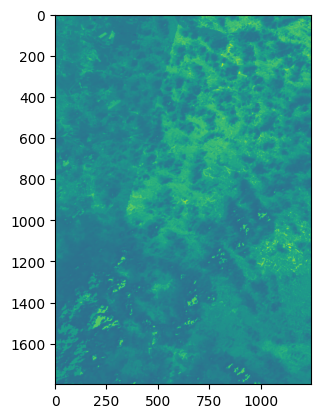

In [31]:
# load data

src = rasterio.open('data/Landsat_NDVI_time_series_1984_to_2024.tif')

# plot data shape

plt.imshow(src.read(1))

In [32]:
ndvi_data: np.ndarray = src.read()
band_names = src.descriptions
print(f"Original NDVI data shape: {ndvi_data.shape}")

# print band names in line by line
for band_name in band_names:
    print(band_name)


Original NDVI data shape: (82, 1798, 1245)
Landsat_NDVI_spring_10-1983_04-1984
Landsat_NDVI_fall_05-1984_09-1984
Landsat_NDVI_spring_10-1984_04-1985
Landsat_NDVI_fall_05-1985_09-1985
Landsat_NDVI_spring_10-1985_04-1986
Landsat_NDVI_fall_05-1986_09-1986
Landsat_NDVI_spring_10-1986_04-1987
Landsat_NDVI_fall_05-1987_09-1987
Landsat_NDVI_spring_10-1987_04-1988
Landsat_NDVI_fall_05-1988_09-1988
Landsat_NDVI_spring_10-1988_04-1989
Landsat_NDVI_fall_05-1989_09-1989
Landsat_NDVI_spring_10-1989_04-1990
Landsat_NDVI_fall_05-1990_09-1990
Landsat_NDVI_spring_10-1990_04-1991
Landsat_NDVI_fall_05-1991_09-1991
Landsat_NDVI_spring_10-1991_04-1992
Landsat_NDVI_fall_05-1992_09-1992
Landsat_NDVI_spring_10-1992_04-1993
Landsat_NDVI_fall_05-1993_09-1993
Landsat_NDVI_spring_10-1993_04-1994
Landsat_NDVI_fall_05-1994_09-1994
Landsat_NDVI_spring_10-1994_04-1995
Landsat_NDVI_fall_05-1995_09-1995
Landsat_NDVI_spring_10-1995_04-1996
Landsat_NDVI_fall_05-1996_09-1996
Landsat_NDVI_spring_10-1996_04-1997
Landsat_NDV

In [33]:
# After loading the data, add these cells:

def extract_date_from_band_name(band_name: str) -> tuple[int, int]:
    """Extract month and year from band name.
    
    Args:
        band_name: Band name in format 'Landsat_NDVI_season_MM-YYYY_MM-YYYY'
        
    Returns:
        tuple: (month, year) where month is from first date (10->1, 5->7) and year is from second date
    """
    # Split by underscore and get the date parts
    parts = band_name.split('_')
    # Get first date part for month
    first_date = parts[3]
    month = int(first_date.split('-')[0])
    
    # Get second date part for year
    second_date = parts[4] 
    year = int(second_date.split('-')[1])
    
    # Map months according to requirements
    if month == 10:
        month = 1
    elif month == 5:
        month = 7
        
    return month, year

# Get coordinates for each pixel
height = ndvi_data.shape[1]
width = ndvi_data.shape[2]

# Get lat/lon for each pixel using rasterio's transform
lats = np.zeros((height, width))
lons = np.zeros((height, width))

for i in range(height):
    for j in range(width):
        lon, lat = src.xy(i, j)
        lats[i,j] = lat
        lons[i,j] = lon

# Create arrays for months and years
months = []
years = []
for band_name in band_names:
    month, year = extract_date_from_band_name(band_name)
    months.append(month)
    years.append(year)

# Reshape data into 2D array where each row is a pixel-time observation
n_timesteps = len(band_names)
n_pixels = height * width

# Create feature matrix
X = np.zeros((n_pixels * n_timesteps, 5))  # 5 features: NDVI, month, year, lat, lon

for t in range(n_timesteps):
    start_idx = t * n_pixels
    end_idx = (t + 1) * n_pixels
    
    # NDVI values
    X[start_idx:end_idx, 0] = ndvi_data[t].flatten()
    
    # Month
    X[start_idx:end_idx, 1] = months[t]
    
    # Year 
    X[start_idx:end_idx, 2] = years[t]
    
    # Lat/Lon
    X[start_idx:end_idx, 3] = lats.flatten()
    X[start_idx:end_idx, 4] = lons.flatten()

# Create DataFrame for easier handling
import pandas as pd

df = pd.DataFrame(
    X, 
    columns=['ndvi', 'month', 'year', 'latitude', 'longitude']
)

In [34]:
# Display first few rows and basic statistics
print("\nFirst few rows of transformed data:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())


First few rows of transformed data:
       ndvi  month    year   latitude  longitude
0  0.229720    1.0  1984.0  31.787291  34.746611
1  0.251121    1.0  1984.0  31.787291  34.746880
2  0.249638    1.0  1984.0  31.787291  34.747150
3  0.249638    1.0  1984.0  31.787291  34.747419
4  0.214027    1.0  1984.0  31.787291  34.747689

Basic statistics:
               ndvi        month          year      latitude     longitude
count  1.835578e+08  183557820.0  1.835578e+08  1.835578e+08  1.835578e+08
mean   2.437664e-01          4.0  2.004000e+03  3.154515e+01  3.491424e+01
std    1.261319e-01          3.0  1.183216e+01  1.398779e-01  9.685647e-02
min   -5.713924e-01          1.0  1.984000e+03  3.130301e+01  3.474661e+01
25%    1.458493e-01          1.0  1.994000e+03  3.142401e+01  3.483042e+01
50%    2.149384e-01          4.0  2.004000e+03  3.154515e+01  3.491424e+01
75%    3.210673e-01          7.0  2.014000e+03  3.166629e+01  3.499805e+01
max    8.784911e-01          7.0  2.024000e+03  3.

In [35]:
# transform df into numpy array

df_array = df.to_numpy()

print(df_array.shape)

# restore it to size of original data (82, 1798, 1245, 5)
df_numpy = df_array.reshape(82, 1798, 1245, 5)

print(df_numpy.shape)




(183557820, 5)
(82, 1798, 1245, 5)


In [36]:
# print the 5 timestamps of pixel in (100,100) in float format without "e"
np.set_printoptions(suppress=True, precision=10, floatmode='fixed')
print(df_numpy[:5, 100,100,:].astype(float))

# print lat and lon of pixel in 0,0  (1,1)
print(lats[0,0], lons[0,0])
print(lats[1,1], lons[1,1])



[[   0.1199689880    1.0000000000 1984.0000000000   31.7603411119
    34.7735600694]
 [   0.1495894641    7.0000000000 1984.0000000000   31.7603411119
    34.7735600694]
 [   0.1242037266    1.0000000000 1985.0000000000   31.7603411119
    34.7735600694]
 [   0.5112252235    7.0000000000 1985.0000000000   31.7603411119
    34.7735600694]
 [   0.1577365994    1.0000000000 1986.0000000000   31.7603411119
    34.7735600694]]
31.787290570447126 34.74661061092207
31.78702107586189 34.7468801055073


In [37]:
# store to disk both numpy and pandas dataframes as parquet

df.to_parquet('data/Landsat_NDVI_time_series_1984_to_2024.parquet')
np.save('data/Landsat_NDVI_time_series_1984_to_2024.npy', df_numpy)


In [38]:
# save numpy into npz file with metadata the describe the data created it here

data_description = {
    'description': 'Landsat NDVI time series 1984 to 2024',
    'dimensions': df_numpy.shape,
    'features (last dimension)': ['ndvi', 'month', 'year', 'latitude', 'longitude'],
    'timesteps': len(band_names),
    'pixels': height * width,
}

print(data_description)

import json 
# save data_description to disk
with open('data/Landsat_NDVI_time_series_1984_to_2024.json', 'w') as f:
    json.dump(data_description, f)

{'description': 'Landsat NDVI time series 1984 to 2024', 'dimensions': (82, 1798, 1245, 5), 'features (last dimension)': ['ndvi', 'month', 'year', 'latitude', 'longitude'], 'timesteps': 82, 'pixels': 2238510}


NameError: name 'plt' is not defined